## Dataset definition

In [1]:
import torch
import numpy as np
import pandas as pd
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from PIL import Image
import math
import torch.backends.cudnn as cudnn

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
  print('CUDA is not available.  Training on CPU ...')
else:
  print('CUDA is available!  Training on GPU ...')

### when using google colab + google drive
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Image and Video recognition
root = "/content/drive/MyDrive/Colab Notebooks/Image and Video recognition/"
### when running locally
# %cd C:\Users\user\OneDrive - m.titech.ac.jp\Work\TokyoTech\M1\Image and Video Recognition\project\dataset_exp
# root = ""

class CustomDatasetFromCSV(Dataset):
    def __init__(self, csv_path, transform = None):
        self.data = pd.read_csv(root + "dataset/" + csv_path)
        self.contents = np.asarray(self.data['content'])
        self.fontencoder = LabelEncoder()
        self.fonts = self.fontencoder.fit_transform(np.asarray(self.data['font']))
        self.authors = np.asarray(self.data['author'])
        self.num_data = len(self.contents)
        self.num_classes = len(self.fontencoder.classes_)
        self.images = np.asarray([ np.array(Image.open(root + "dataset/" + self.data['word_path'][i])) / 255. for i in tqdm(range(self.num_data)) ])

    def __getitem__(self, index):
        image = self.images[index]
        content = self.contents[index]
        font = self.fonts[index]
        author = self.authors[index]
        return image, content, font, author

    def __len__(self):
        return self.num_data

CUDA is available!  Training on GPU ...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/Image and Video recognition


In [2]:
def split_dataset(dataset, batch_size, split_size, method = "all", shuffle_dataset = True):
  if method == "all":
    indices = list(range(len(dataset)))
    if shuffle_dataset :
        np.random.seed(0)
        np.random.shuffle(indices)

    split_1 = int(np.floor(split_size[0] * len(dataset)))
    split_2 = int(np.floor((split_size[0] + split_size[1]) * len(dataset)))
    train_indices, val_indices, test_indices = indices[:split_1], indices[split_1:split_2], indices[split_2:]
  else:
    print("wrong method!!")

  # Creating PT data samplers and loaders:
  train_sampler = SubsetRandomSampler(train_indices)
  valid_sampler = SubsetRandomSampler(val_indices)
  test_sampler = SubsetRandomSampler(test_indices)
  train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
  validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)
  test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

  return train_loader, validation_loader, test_loader

## ResNet model definition
https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

In [3]:
from typing import Type, Any, Callable, Union, List, Optional

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 1000,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        # _log_api_usage_once(self)
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)



## SE-ResNet, SE-ResNeXt model definition  
https://github.com/StickCui/PyTorch-SE-ResNet

In [4]:
class SEBottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        # SE
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.conv_down = nn.Conv2d(
            planes * 4, planes // 4, kernel_size=1, bias=False)
        self.conv_up = nn.Conv2d(
            planes // 4, planes * 4, kernel_size=1, bias=False)
        self.sig = nn.Sigmoid()
        # Downsample
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out1 = self.global_pool(out)
        out1 = self.conv_down(out1)
        out1 = self.relu(out1)
        out1 = self.conv_up(out1)
        out1 = self.sig(out1)

        if self.downsample is not None:
            residual = self.downsample(x)

        res = out1 * out + residual
        res = self.relu(res)

        return res

class SEResNet(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(SEResNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

###### SEResNeXt

class Selayer(nn.Module):

    def __init__(self, inplanes):
        super(Selayer, self).__init__()
        self.global_avgpool = nn.AdaptiveAvgPool2d(1)
        self.conv1 = nn.Conv2d(inplanes, inplanes // 16, kernel_size=1, stride=1)
        self.conv2 = nn.Conv2d(inplanes // 16, inplanes, kernel_size=1, stride=1)
        
        self.relu = nn.ReLU(inplace=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):

        out = self.global_avgpool(x)

        out = self.conv1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.sigmoid(out)

        return x * out

class BottleneckX(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, cardinality, stride=1, downsample=None):
        super(BottleneckX, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)

        self.conv2 = nn.Conv2d(planes * 2, planes * 2, kernel_size=3, stride=stride,
                               padding=1, groups=cardinality, bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 2)

        self.conv3 = nn.Conv2d(planes * 2, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)

        self.selayer = Selayer(planes * 4)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        out = self.selayer(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

class SEResNeXt(nn.Module):

    def __init__(self, block, layers, cardinality=32, num_classes=1000):
        super(SEResNeXt, self).__init__()
        self.cardinality = cardinality
        self.inplanes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, self.cardinality, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, self.cardinality))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)

        return x
  

## Instantiated dataset, model and optimizer

In [5]:
annotated_file = "annotated_merged_deleted_x_2.csv"
dataset = CustomDatasetFromCSV(annotated_file)

batch_size = 16
split_size = [0.8, 0.1, 0.1]
train_loader, valid_loader, test_loader = split_dataset(dataset, batch_size, split_size, method = "all", shuffle_dataset = True)

ResNet18 = ResNet(BasicBlock, [2,2,2,2], num_classes = dataset.num_classes)
# ResNet34 = ResNet(BasicBlock, [3,4,6,3], num_classes = dataset.num_classes)
# ResNet50 = ResNet(Bottleneck, [3,4,6,3], num_classes = dataset.num_classes)
# ResNet101 = ResNet(Bottleneck, [3,4,23,3], num_classes = dataset.num_classes)
# ResNet152 = ResNet(Bottleneck, [3,8,36,3], num_classes = dataset.num_classes)
# SE_ResNet50 = SEResNet(SEBottleneck, [3, 4, 6, 3], num_classes = dataset.num_classes)
# SE_ResNet101 = SEResNet(SEBottleneck, [3, 4, 23, 3], num_classes = dataset.num_classes)
# SE_ResNet152 = SEResNet(SEBottleneck, [3, 8, 36, 3], num_classes = dataset.num_classes)
# SE_ResNext50 = SEResNeXt(BottleneckX, [3, 4, 6, 3], num_classes = dataset.num_classes)
# SE_ResNext101 = SEResNeXt(BottleneckX, [3, 4, 23, 3], num_classes = dataset.num_classes)
# SE_ResNext152 = SEResNeXt(BottleneckX, [3, 8, 36, 3], num_classes = dataset.num_classes)

model = ResNet18
modelname = "ResNet18"
model_path = 'models/font_classification/'
# print(model)

if train_on_gpu:
  model = torch.nn.DataParallel(model)
  cudnn.benchmark = True

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)


100%|██████████| 2896/2896 [00:03<00:00, 789.15it/s]


## Train model for basic classification



In [6]:
# number of epochs to train the model
n_epochs = 20
valid_loss_min = np.Inf # track change in validation loss
train_loss_list = []
valid_loss_list = []

for epoch in range(1, n_epochs+1):
  # keep track of training and validation loss
  train_loss = 0.0
  valid_loss = 0.0
    
  ###################
  # train the model #
  ###################
  model.train()
  for batch_idx, (images, contents, fonts, authors) in enumerate(train_loader):
    resize = transforms.Compose([transforms.Resize(224)])
    data = resize(images.unsqueeze(1)).float()
    target = fonts.long()
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # clear the gradients of all optimized variables
    optimizer.zero_grad()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # backward pass: compute gradient of the loss with respect to model parameters
    loss.backward()
    # perform a single optimization step (parameter update)
    optimizer.step()
    # update training loss
    train_loss += loss.item()*data.size(0)
        
  ######################    
  # validate the model #
  ######################
  model.eval()
  for batch_idx, (images, contents, fonts, authors) in enumerate(valid_loader):
    resize = transforms.Compose([transforms.Resize(224)])
    data = resize(images.unsqueeze(1)).float()
    target = fonts.long()
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
      data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update average validation loss 
    valid_loss += loss.item()*data.size(0)
    
  # calculate average losses
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)
  train_loss_list.append(train_loss)
  valid_loss_list.append(valid_loss)
        
  # print training/validation statistics 
  print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
      epoch, train_loss, valid_loss))
    
  # save model if validation loss has decreased
  if valid_loss <= valid_loss_min:
    print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
    valid_loss_min,
    valid_loss))
    torch.save(model.state_dict(), model_path + modelname + '.pt')
    valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.251088 	Validation Loss: 1.079592
Validation loss decreased (inf --> 1.079592).  Saving model ...
Epoch: 2 	Training Loss: 0.866664 	Validation Loss: 4.861568
Epoch: 3 	Training Loss: 0.672199 	Validation Loss: 0.885420
Validation loss decreased (1.079592 --> 0.885420).  Saving model ...
Epoch: 4 	Training Loss: 0.517685 	Validation Loss: 2.108180
Epoch: 5 	Training Loss: 0.388801 	Validation Loss: 0.762166
Validation loss decreased (0.885420 --> 0.762166).  Saving model ...
Epoch: 6 	Training Loss: 0.336503 	Validation Loss: 1.151860
Epoch: 7 	Training Loss: 0.176502 	Validation Loss: 0.607454
Validation loss decreased (0.762166 --> 0.607454).  Saving model ...
Epoch: 8 	Training Loss: 0.146220 	Validation Loss: 1.099291
Epoch: 9 	Training Loss: 0.131123 	Validation Loss: 0.626876
Epoch: 10 	Training Loss: 0.107637 	Validation Loss: 1.138271
Epoch: 11 	Training Loss: 0.121620 	Validation Loss: 9.132095
Epoch: 12 	Training Loss: 0.068926 	Validation Loss: 0.9

## Test model for basic classification

In [7]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.load_state_dict(torch.load(model_path + modelname + '.pt'))

model.eval()
# iterate over test data
for batch_idx, (images, contents, fonts, authors) in enumerate(test_loader):
  resize = transforms.Compose([transforms.Resize(224)])
  data = resize(images.unsqueeze(1)).float()
  target = fonts.long()
  # move tensors to GPU if CUDA is available
  if train_on_gpu:
    data, target = data.cuda(), target.cuda()
  # forward pass: compute predicted outputs by passing inputs to the model
  output = model(data)
  # calculate the batch loss
  loss = criterion(output, target)
  # update test loss 
  test_loss += loss.item()*data.size(0)
  # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)    
  # compare predictions to true label
  correct_tensor = pred.eq(target.data.view_as(pred))
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  # calculate test accuracy for each object class
  for i in range(min(batch_size, len(target.data))):
    label = target.data[i]
    class_correct[label] += correct[i].item()
    class_total[label] += 1

# average test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(dataset.num_classes):
  if class_total[i] > 0:
    print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
        dataset.fontencoder.classes_[i], 100 * class_correct[i] / class_total[i],
        np.sum(class_correct[i]), np.sum(class_total[i])))
  else:
    print('Test Accuracy of %5s: N/A (no training examples)' % (dataset.fontencoder.classes_[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.068514

Test Accuracy of clerical: 100% ( 5/ 5)
Test Accuracy of cursive: 79% (47/59)
Test Accuracy of regular: 76% (48/63)
Test Accuracy of  seal: 83% (10/12)
Test Accuracy of semi-cursive: 74% (112/151)

Test Accuracy (Overall): 76% (222/290)


## Visualize results

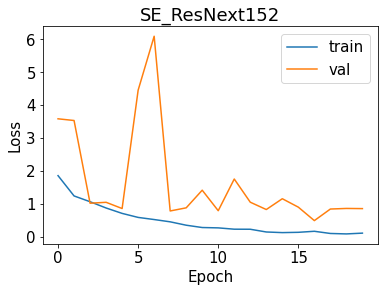

In [10]:
import matplotlib.pyplot as plt

# plt.rcParams["figure.figsize"] = (15,10)
plt.rc('font', size=15)    

plt.plot(range(n_epochs), train_loss_list, label="train")
plt.plot(range(n_epochs), valid_loss_list, label="val")

plt.title(modelname)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
accuracy = {}  # reset

In [13]:
accuracy = {
    'ResNet18': [80.0, 94.91525423728814, 79.36507936507937, 25.0, 62.913907284768214, 71.72413793103448],
    'ResNet50': [0.0, 49.152542372881356, 61.904761904761905, 41.666666666666664, 93.37748344370861, 73.79310344827586], 
    'ResNet152': [80.0, 72.88135593220339, 71.42857142857143, 66.66666666666667, 88.0794701986755, 80.34482758620689], 
    'SE_ResNet50': [100.0, 89.83050847457628, 85.71428571428571, 50.0, 62.25165562913907, 73.10344827586206], 
    'SE_ResNext50': [100.0, 69.49152542372882, 76.19047619047619, 83.33333333333333, 84.10596026490066, 79.65517241379311],
    'SE_ResNet152': [80.0, 69.0, 85.0, 75.0, 84.0, 81.0],
    'SE_ResNext152': [100.0, 84.0, 82.0, 83.0, 78.0, 81.0]
}

In [ ]:
accuracy[modelname] = [100. * class_correct[i] / class_total[i] for i in range(dataset.num_classes)] + [100. * np.sum(class_correct) / np.sum(class_total)]

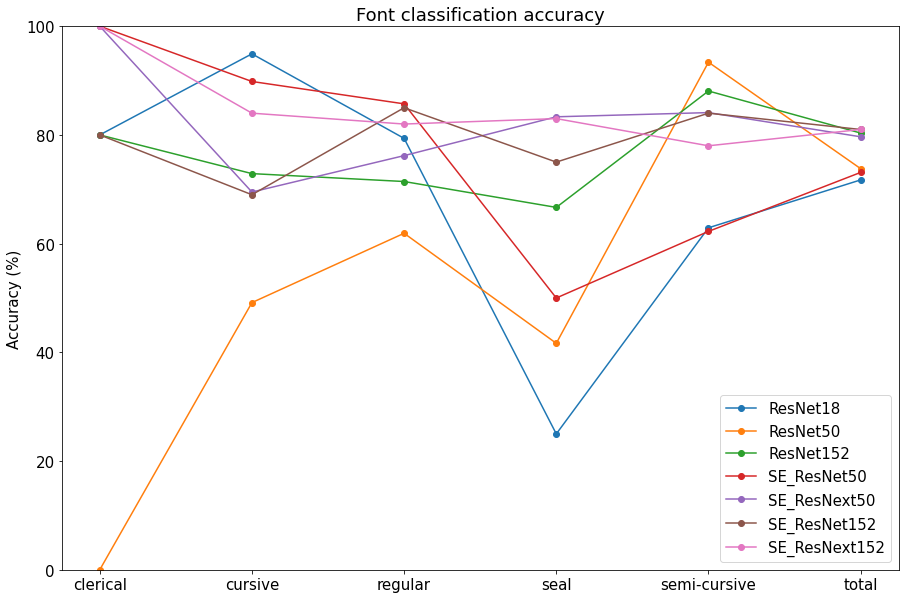

In [14]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,10)
plt.rc('font', size=15)    

for i, model_name in enumerate(accuracy.keys()):
  plt.plot(range(dataset.num_classes+1), accuracy[model_name], marker = 'o',  label=model_name)

xlabels = dataset.fontencoder.classes_.tolist() + ["total"]
plt.xticks(np.arange(len(xlabels)), xlabels)
plt.title('Font classification accuracy')
plt.ylabel('Accuracy (%)')
plt.ylim(0,100)
plt.legend()
plt.show()